## MNIST Exploration
#### Hands-On ML Chapter 3

### NOTE: X is the data, y is the target class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
y.shape

(70000,)

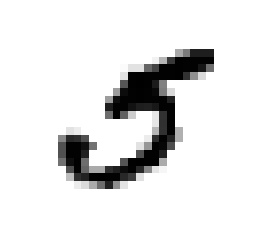

In [5]:
% matplotlib inline
import matplotlib

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

5.0

sklearn provides built in data sets, one of which is a bunch of images of written numbers. You can see that we used matplotlib's imshow() function to display an image of the number. It's a 28x28 image, so there's 784 pieces of data per each column (0, 255) each representing a shade of black and white. This data set is already split up into a training and test sets for us.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
X_train[[30012, 1]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Aurelien uses numpy's random permutation function here. Some explanation: if you call X_train by itself, it will display the array in a default order. If you provide a list of indeces, it will provide the rows that you asked for in the specified order. Thus, when we run random permutation, we get a list of 60000 shuffled numbers, and then we pass that as an argument to the array, which then returns a different array based on the shuffled list, which we save into a variable. The permutation function does not shuffle it inplace. Sklearn also provides a shuffle function that does not affect the original array, but numpy has its own shuffle function that will simply do it in place. It will modify the original array.

The sklearn shuffle is in sklearn.utils

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) # These are the target classifications for each image

Above, we're creating target classifications as either 5 or not-5, thus, a binary classifier. 

Aurelien wants us to use a stochastic gradient descent in order to classify images. This is a classifier that orbits around the middle term 'gradient'. Gradient is issentially the slope of a function in terms multivariable calculus. This means that it it represents the slope as a vector. From Wikipedia, "...the gradient points in the direction of the greatest rate of increase of the function, and its magnitude is the slope of the graph in that direction." Descent describes a method of searching for values using the gradient, and stochastic is a stipulation to this function on how samples are taken and how to iterate through them. There is also batch gradient descent. In sum, stochastic gradient descent is an algorithm to find the max or min of a function using the gradient of that function using sample subsets and fewer iterations. Aurelien will talk about this in more detail later, and it will be discussed in multivariable calculus (calculus III).

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

I needed to take a second to wrap my head around what we did here. We passed the array of values and a list of booleans to the classifier. We're not explicitly telling the classifier what a 5 is. In this instance, we're just passing booleans, and guesses if something is true or false based on the arrangement of the pixels. We can make another list of booleans based on whichever number we wanted and do the same thing. 

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


Aurelien demonstrates here that it's relatively easy to implement your own version of cross_val_score. sklearn has a nice stratifiedkfold class that does everything in its name: it stratifies the sample(I'm not really sure how it goes about determing how to stratify it), and it divides the data into 3 sets (you can pass n_splits into it, but the default is 3, which is what we wanted). When we run the split method of this class on the X-train and y-train-5 sets, it returns an ndarray of indices where to split the training and test partitions, this case, 3 sets of indices. We then clone our previous SGD classifier (this just clones the classifier we instantiated without fitting it to any data). We put the split groups into variables, which we then fit and predict(using the test data) using our classifier and returns a proportion of the number of correct predictions.

### .split() returns a generator consisting of a tuple of numpy arrays containing the test and train indices.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

We made a stupid classifier of the base estimator and it was almost just as accurate as our other model since only about 10% of the images 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. This qualifies as a *skewed dataset*, since some classes are more frequent than others.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict returns the prediction of a particular row in the data when that row was in the test set. In this case, X_train has 60000 images in it, and we have 3 folds. So, for 3 iterations, 20000 pieces of data are in the test set, and the rest are in the training set. Whereas cross_val_score returned the proportion of correct predictions, this just returns the prediction outright. So we have an array of 60000 predictions.

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

## Precision vs. Recall

In [19]:
#### Illustration of Confusion Matrix

pd.DataFrame(np.array([[53843, 736], [2047, 3374]]),
             columns=['predicted non-5', 'predicted 5'],
             index=['actual non-5', 'actual 5'])

,predicted non-5,predicted 5
actual non-5,53843,736
actual 5,2047,3374


first row = negative class

second row = positive class

first column, first row = true negatives

second column, first row = false positives

first column, second row = false negatives

second column, second row = true positives

### Precision

$$precision = \frac{TP}{TP + FP}$$

TP = # True Positives
FP = # False Positives

Number of correctly identified 5s divided by total number of images predicted as 5

### Recall

$$recall = \frac{TP}{TP + FN}$$

FN = # False Negatives

Number of correctly identified 5s divided by the total number of 5s

In [20]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

0.768713502035 0.801328168235


We can combine these scores into an F1 score, the harmonic mean of both. We use the harmonic mean since it is more sensitive to outliers, smaller numbers in this case. 

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [21]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.784682080925


In [22]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

Using the predict() method will return its evaluation of value that we pass into the method. Here, we can see the result of the decision function itself. The threshold is set fairly low as we see here, which is demonstrating how the predict() method arrived at its conclusion. We'll now raise the threshold to see what happens.

Side note: I was getting slightly different numbers than Aurelien until I reached this point. It turns out he set his random seed at the beginning of his notebook to 42, which I never did. It's been corrected.

In [23]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

So raising the threshold will decrease the recall. 

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

By passing a method parameter, we're getting the number used to make the prediction rather than the prediction itself. s

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

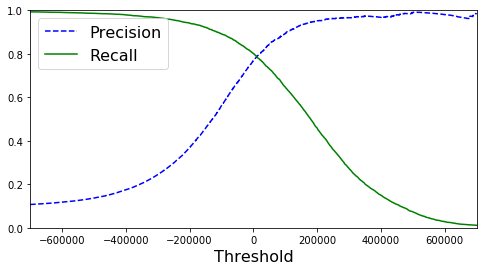

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

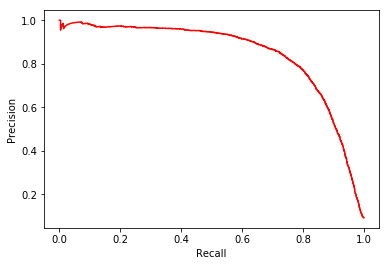

In [27]:
def plot_recall_vs_precision(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "r-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

plot_recall_vs_precision(precisions, recalls)

Now we can use these graphs to tailor our threshold depending on what meets our needs (greater recall vs greater precision). We can't pass the function directly what threshold we need, but we can determine what scores are greater than the threshold and pass this into our function.

In [28]:
y_train_pred_90 = (y_scores > 70000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.865920511649
0.699317469102


## ROC Curves

Receiver Operating Characteristic Curve

Some import definitions when talking about ROC curves:
    
*specificity* = **TNR** True Negative Rate, or the ratio of instances correctly identified as non-instances

*sensitivity* = **TPR** True Positive Rate, or the ratio of correctly identified instances 

ROC plots *sensitivity* versus 1 - *specificity* (the FPR)

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

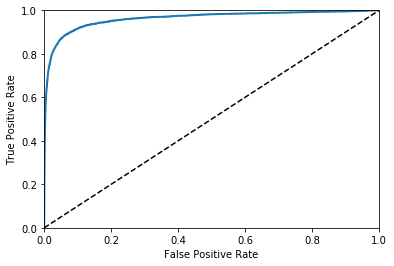

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96244965559671547

Aurelien makes a distinction on when to use the precision/recall curve vs when to use the ROC curve. 

Use the PR curve when the positive class is rare or when we care more about false positives than false negatives.

Use the ROC curve otherwise.

In this case, the AUC score seems to indicate that we have a pretty good classifier. But 

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # Get the positive probabilities as a numpy array
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

y_probas_forest returns row for each instance and a column for each class (in this case, the first column is the negative class, or not-5, and the second is the positive class, or 5).

## Side notes follow

In [33]:
# I have to nail down this colon-comma syntax. I can no longer tolerate not understanding its interpretation.

x = np.array([[ 0,  1,  2],
             [ 3,  4,  5],
             [ 6,  7,  8],           
             [ 9, 10, 11]])
print("All rows and all columns:")
print(x[:,:], "\n")
print("Only row at index 2:")
print(x[2,], "\n")
print("Only column at index 2:")
print(x[:,2:], "\n")
print("Column index 2 as a row:")
print(x[:, 2], "\n")
print("Value at row index 3 and column index 1:")
print(x[3,1])

All rows and all columns:
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]] 

Only row at index 2:
[6 7 8] 

Only column at index 2:
[[ 2]
 [ 5]
 [ 8]
 [11]] 

Column index 2 as a row:
[ 2  5  8 11] 

Value at row index 3 and column index 1:
10


For numpy arrays, the comma separates rows and columns, so the notation would be:

    array[rows, columns]

Within the brackets normal slicing applies. 

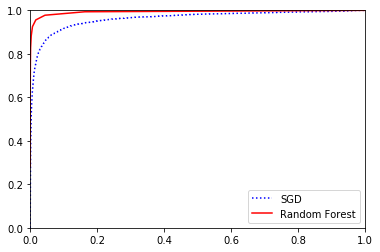

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, "r-", label="Random Forest")
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

## Multiclass Classification

So far we've done strictly binary classification. When it comes to multiclass classification, there are a number of different approaches. 

*One-versus-all*: Train the several binary classifiers, one for each class (so one classifier that can identify between class positive and class negative). You would then select the classifier that returned the highest score for that image.

'*One-versus-one*: Train a binary classifier on a pair of classes, such that the positive class and negative class would be something vs a different something rather than something vs not-something (1 vs 2, 3 vs 4, and so on). A greater number of classifiers are required for this, but each classifier is required to be trained only on the part of the training set for the two classes it has to distinguish.

SVMs scale poorly with the size of the training set, so they may prefer OvO in most cases; however, most binary classification algorithms perform better with OvA.



In [36]:
sgd_clf.fit(X_train, y_train) # multiclass classification
sgd_clf.predict([some_digit])

array([ 5.])

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores # You can see that five has the highest score

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [38]:
print(np.argmax(some_digit_scores),
      sgd_clf.classes_,
      sgd_clf.classes_[5])


5 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.] 5.0


We can tell sklearn to use OvO or OvA using their respective classes.

In [39]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [41]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

sklearn did not have to detect/use OvA or OvO since Random Forests can directly classify instances into multiple classes.

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84063187,  0.84899245,  0.86652998])

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91011798,  0.90874544,  0.906636  ])

## Error Analysis

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

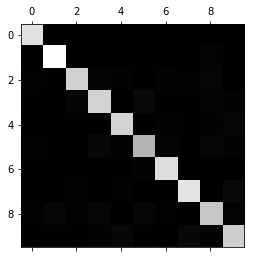

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[  9.66570994e-01,   5.06500084e-04,   4.05200068e-03,
          1.51950025e-03,   1.68833361e-03,   8.27283471e-03,
          8.44166807e-03,   1.68833361e-03,   6.58450110e-03,
          6.75333446e-04],
       [  2.96647879e-04,   9.63067339e-01,   6.37792940e-03,
          3.70809849e-03,   1.03826758e-03,   5.93295758e-03,
          7.41619697e-04,   1.48323939e-03,   1.61673094e-02,
          1.18659152e-03],
       [  8.55991944e-03,   6.88150386e-03,   8.93084928e-01,
          1.74555220e-02,   1.49378986e-02,   4.36388050e-03,
          1.46022155e-02,   1.00704935e-02,   2.78616986e-02,
          2.18194025e-03],
       [  7.66595988e-03,   7.50285435e-03,   2.29978796e-02,
          8.71309737e-01,   1.63105529e-04,   3.76773773e-02,
          6.52422117e-03,   8.15527646e-03,   2.29978796e-02,
          1.50057087e-02],
       [  3.25231085e-03,   4.96405341e-03,   7.01814447e-03,
          1.71174255e-03,   9.18521054e-01,   1.54056830e-03,
          9.58575830e-03

What we did here: setting the axis parameter to 1 tells the sum method to take the sum along the row (so passing 0 would be a column, think of it as 0=x, 1=y). If we didn't pass the keepdims parameter, it would return a new row full (so one array) of the sums. keepdims will ensure that the values are kept in a column so we can use them for subsequent calculations. The division simply divides each value in the confusion matrix by the sum of that row. Now we have the error percentages.

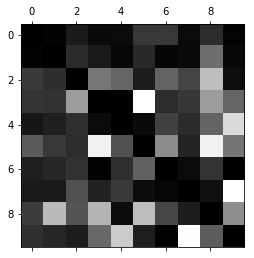

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

I haven't read the next section yet, but I think we set the diagonal squares equal to zero just for visual purposes. We just want to see where the greatest amount of error is occurring, and since the squares going diagonally from the top left to the bottom right are the percentages of correct predictions, we shade them full black to help draw conclusions about the errors elsewhere.

 Now we're going to take a quick look at some of the digits our classifier is having a hard time with, particular 5s and 3s.
 


In [48]:
# I copied and pasted this from Aurelien's notebook since it wasn't defined in the book.
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

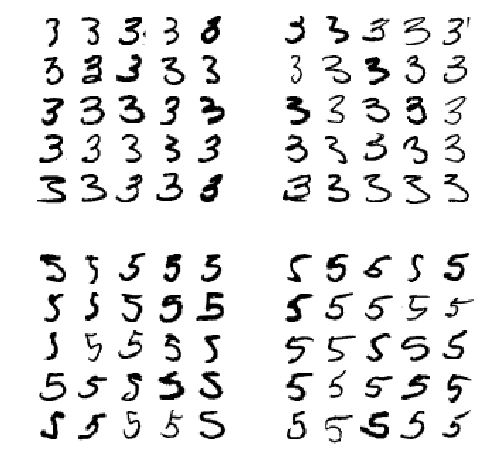

In [49]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

On the left are images classified as 3s, on the right as 5s. It's clear that some of these numbers are poorly written, and by the SGD classifiers work makes them sensitive to minor changes in the shades of pixels. A different classifier or an image preprocessor could be beneficial here.

## Multilabel Classification

You may want your classifier to tell you if it recognizes something as multiple classes. For instance, you could give a classifier the ability to say the image is either a 3 or 5.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Regarding c\_, does it remove duplicates? I dunno.

KNeighbors supports multiple classification. IN this case we concatenate the two sets of data and train a knn_clf on it.

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification

A combination of multilabel and multiclass classification. 

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5500
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(clean_digit)